# Hash tests

The goal of this work if to measure the timing and number of collisions of different hashing algorithms available in Python's hashlib package.

In [16]:
%matplotlib inline

import hashlib
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from IPython.display import Markdown

## The database

The database is composed of 300k users and passwords. I got it from a friend from college. Apparently, this whole thing I'm doing is a project from one of their courses...

Anyway, everything is stored in the file _data.csv_ that we'll load into a pandas DataFrame.

In [2]:
database_file = 'data.csv'
database = pd.read_csv(database_file)
database.head()

,Name,Password
0,Adeline Abujanra,VKYJCZP
1,Adeline Abujanra Albuquerque,AVJRDHLUP
2,Adeline Abujanra Bandit,USJEZMP
3,Adeline Abujanra Barbosa,KGAXGLTS
4,Adeline Abujanra Branco,VGNQZHPUU


Passwords are originally stored as Caesar ciphers shifted by 12 characters, so in case they are still ciphered, we'll create a new column with the unciphered passwords and save it to the database file so we'll never have to do it again.

In [3]:
def caesar(plainText, shift):
    """Caesar Cipher implementation.
       Upper and lower case letters are kept accordingly, non-alphabetic characters are ignored.
       Implementation taken from here: https://stackoverflow.com/q/8886947/1245214
       
       :param plainText: the text to be ciphered
       :param shift: shift value for the cipher
       :return: the ciphered text
    """
    cipherText = ""
    
    for ch in plainText:
        finalLetter = ch
        if ch.isalpha():
            finalLetter = chr((ord(ch.lower()) - 97 + shift) % 26 + 97)        
        if ch.isupper():
            finalLetter = finalLetter.upper()

        cipherText += finalLetter

    return cipherText

if 'Cypher' in database.columns and 'Password' not in database.columns:
    database['Password'] = [caesar(x[1][1], -12) for x in tqdm(database.iterrows(), total=database.shape[0])]
    database.to_csv(database_file, index=None)

elif 'Password' in database.columns and 'Cypher' not in database.columns:
    database['Cypher'] = [caesar(x[1][1], 12) for x in tqdm(database.iterrows(), total=database.shape[0])]
    database.to_csv(database_file, index=None)

100%|██████████| 300000/300000 [00:14<00:00, 20194.31it/s]


Originally, one of the passwords (`URZRPUC`) was duplicated, so I just changed it to make all passwords unique. As you can see below, the most frequent password appears only once, so everything is ready for our tests.

In [28]:
display(database['Password'].describe())

We'll keep only the passwords in a list and remove the whole dataset from memory.

In [4]:
passwords = list(database['Password'])
del database

Here we'll declare a DataFrame where our calculated hashes we'll be saved for further studies. Also, we put all hash functions in a list and give them user-friendly names.

In [5]:
# we'll save hashes into a file the first time they are produced...
hashes_file = 'hashes.csv'
hashes = pd.DataFrame()

times = []

# Which algorithms we are going to test
experiments = [('BLAKE2B', hashlib.blake2b),
               ('BLAKE2S', hashlib.blake2s),
               ('MD5', hashlib.md5),
               ('SHA1', hashlib.sha1),
               ('SHA224', hashlib.sha224),
               ('SHA256', hashlib.sha256),
               ('SHA384', hashlib.sha384),
               ('SHA512', hashlib.sha512),
               ('SHA3-224', hashlib.sha3_224),
               ('SHA3-256', hashlib.sha3_256),
               ('SHA3-384', hashlib.sha3_384),
               ('SHA3-512', hashlib.sha3_512)]

# How many times we are going to hash all passwords in the database, with each algorithm
num_experiments = 150

Here we run our experiments. The database has 300k passwords, and we are going to hash all of them `num_experiments` times, for each algorithm listed in `experiments`.

In [6]:
# For each algorithm...

pbar = tqdm(total = len(experiments) * num_experiments * len(passwords))
for algo_number, (algo_name, algo_function) in enumerate(experiments):    
    for i in range(num_experiments):
        pbar.desc = 'Algo ' + str(algo_number + 1) + '/' + str(len(experiments)) + ' (' + str(i + 1) + '/' + str(num_experiments) + ')'
        t = 0
        hashes_list = []
        for password in passwords:
            pbar.update()
            
            # small fact: when loading a file into a pandas DataFrame, you can actually  tell
            # what's the encoding of the file:

            # >>>> database = pd.read_csv(database_file)

            # But since here we are iterating over rows,
            # we have to explicitly encode our strings AGAIN before hashing them,
            # so I don't even bother telling pandas the file encoding in the first place...            
            # create our hashing object
            m = algo_function()
            m.update(password.encode('utf-8'))
            
            # we only time this part of the code
            # ==================================
            start = time.time()
            hashe = str(m.hexdigest())
            end = time.time()
            # ==================================
            
            t += end - start
            
            if algo_name not in hashes.columns:
                hashes_list.append(hashe)

        # results are appended to a list
        times.append((algo_name, t))
        
        # We are going to save the hashes to our database, in case they don't still exist
        if algo_name not in hashes.columns:
            hashes[algo_name] = hashes_list
            hashes.to_csv(hashes_file, index=None)

Algo 12/12 (150/150): 100%|█████████▉| 539999459/540000000 [16:49<00:00, 574035.20it/s]

## The results

Here is a summary of the times achieved by each algorithm. Remember that we are looking at the time it took to hash _all passwords_ in the database.

In [27]:
df = pd.DataFrame(data=times, columns=['Algorithm', 'Time (s)'])
df.to_csv('times.csv')
display(df.groupby('Algorithm').describe())

Time (s)                                                    \
             count      mean       std       min       25%       50%   
Algorithm                                                              
BLAKE2B      150.0  0.153855  0.003512  0.150103  0.151655  0.153011   
BLAKE2S      150.0  0.128589  0.004163  0.124494  0.126676  0.127523   
MD5          150.0  0.124823  0.002233  0.121781  0.123437  0.124419   
SHA1         150.0  0.129734  0.003326  0.126088  0.127723  0.129035   
SHA224       150.0  0.158432  0.003982  0.152159  0.155405  0.157702   
SHA256       150.0  0.157553  0.006940  0.150434  0.153586  0.156105   
SHA3-224     150.0  0.200357  0.004440  0.191892  0.196984  0.199824   
SHA3-256     150.0  0.201426  0.007036  0.192915  0.198216  0.200330   
SHA3-384     150.0  0.205665  0.007912  0.197453  0.201737  0.203769   
SHA3-512     150.0  0.205721  0.007248  0.192717  0.201831  0.204855   
SHA384       150.0  0.183692  0.003632  0.178859  0.181259  0.183224   
SHA512       150.0  0.197302  0.004417  0.190827  0.193775  0.196259   

                               
                75%       max  
Algorithm                      
BLAKE2B    0.154416  0.169882  
BLAKE2S    0.128802  0.152183  
MD5        0.125541  0.136362  
SHA1       0.130334  0.146928  
SHA224     0.160308  0.170946  
SHA256     0.159301  0.207813  
SHA3-224   0.202910  0.213185  
SHA3-256   0.202254  0.256762  
SHA3-384   0.206997  0.268253  
SHA3-512   0.208068  0.239398  
SHA384     0.184692  0.206632  
SHA512     0.200450  0.212117

The boxplot allows us to unveil some more cool info. We can see that BLAKE2b, BLAKE2S, MD5 and SHA-1 are the fastest ones. According to Wikipedia, [BLAKE2b is supposed to be the fastest one of all][blake2b] on x64 machines, but BLAKE2s got the podium, probably because it computes smaller digests than BLAKE2b.

We can also see that most of the more secure hashing functions (from SHA-384 to SHA3-512) have comparable time. Since not all of their boxes overlap, we can't say that they operate in equal time with statistical significance.

There is also a large gap between the SHA-2 family of algorithms: SHA224/256 got similar times, and so did SHA384/512)

[blake2b]: https://en.wikipedia.org/wiki/BLAKE_(hash_function)

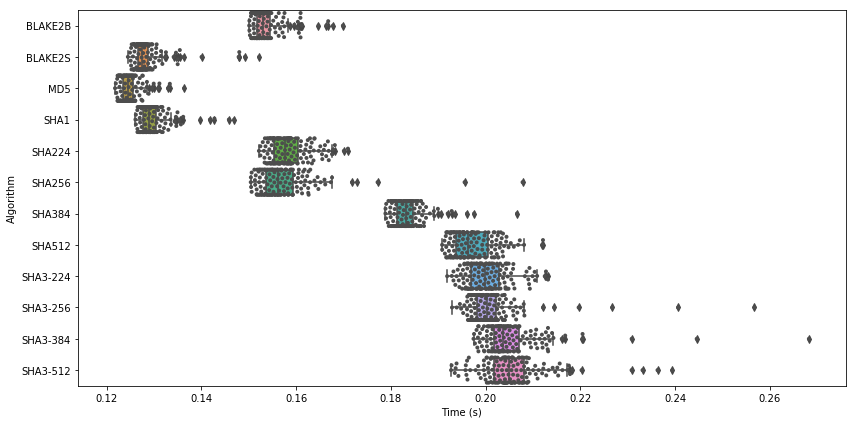

In [28]:
df = pd.read_csv('times.csv')
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(ax=ax, data=df, x='Time (s)', y='Algorithm')
sns.swarmplot(ax=ax, x="Time (s)", y="Algorithm", data=df,
              size=4, color=".3", linewidth=0)
fig.tight_layout()

Here we check for collisions. There are 300k hashes and 300k unique hashes. In short, there were no collisions.

In [41]:
hashes.describe().loc[['count', 'unique']].transpose()

,count,unique
BLAKE2B,300000,300000
BLAKE2S,300000,300000
MD5,300000,300000
SHA1,300000,300000
SHA224,300000,300000
SHA256,300000,300000
SHA384,300000,300000
SHA512,300000,300000
SHA3-224,300000,300000
SHA3-256,300000,300000


Now let's take a look at the length of the digests (the output of the hash functions). As expected, all functions output a string with equal length, everytime they are applied.

In [43]:
hash_lengths = pd.DataFrame(columns=hashes.columns)
for algo_name in hashes.columns:
    hash_lengths[algo_name] = hashes[algo_name].apply(len)

hash_lengths.describe().loc[['mean', 'std']].transpose()

,mean,std
BLAKE2B,128.0,0.0
BLAKE2S,64.0,0.0
MD5,32.0,0.0
SHA1,40.0,0.0
SHA224,56.0,0.0
SHA256,64.0,0.0
SHA384,96.0,0.0
SHA512,128.0,0.0
SHA3-224,56.0,0.0
SHA3-256,64.0,0.0


Here, I plot the hash time of each function as a function of their digest size. By looking at the picture, can't really tell that the length of the digest is responsible for the majority of the processing time of each hash function.

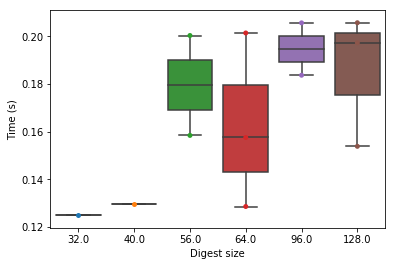

In [44]:
line = pd.DataFrame(data=df.groupby('Algorithm').mean()['Time (s)'])
line['Digest size'] = hash_lengths.mean()

g = sns.boxplot(x="Digest size", y="Time (s)", data=line)
g = sns.swarmplot(x="Digest size", y="Time (s)", data=line)